In [42]:
# import libraries required for this notebook

# import os
import math
from sklearn.linear_model import Perceptron
from sklearn.model_selection import cross_val_score
from pydoc import source_synopsis
from lazypredict.Supervised import LazyClassifier
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import matplotlib.image as mpimg
from matplotlib.colors import ListedColormap
import seaborn as sns
sns.set_theme(style='darkgrid', palette='crest')

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import plot_confusion_matrix
# import joblib


In [2]:
# files used in the model creation process
orig_file = '../datasets/WA_Fn-UseC_-HR-Employee-Attrition.csv'

# files used to store a clean version of the processed data before 
processed_file = '../datasets/HR_attrition_orig_proc.csv'

# files used in the model creation process
train_x_file = '../datasets//HR_attrition_train_x.csv'
test_x_file = '../datasets/HR_attrition_test_x.csv'
train_y_file = '../datasets/HR_attrition_train_y.csv'
test_y_file = '../datasets/HR_attrition_test_y.csv'

train_x_nb_file = '../datasets/HR_attrition_train_x_nb.csv'
test_x_nb_file = '../datasets/HR_attrition_test_x_nb.csv'

train_x_lr_file = '../datasets/HR_attrition_train_x_lr.csv'
test_x_lr_file = '../datasets/HR_attrition_test_x_lr.csv'
train_x_nn_file = '../datasets/HR_attrition_train_x_nn.csv'
test_x_nn_file = '../datasets/HR_attrition_test_x_nn.csv'


In [3]:

# Constants

ISRESIGNED_T = 'Attrition'

# employee related information
AGE = 'Age'
EDUCATION_T = 'EducationField'
GENDER_T = 'Gender'
COMPANIES = 'NumCompaniesWorked'
STATUS_T = 'MaritalStatus'
HOMEDISTANCE = 'DistanceFromHome'

# role of the employee in the company
ROLE_T = 'JobRole'
LEVEL = 'JobLevel'
DEPARTMENT_T = 'Department'
YEARSCOMPANY = 'YearsAtCompany'
YEARSEMPLOYED = 'TotalWorkingYears'
YEARSROLE = 'YearsInCurrentRole'
YEARSLASTPROMO = 'YearsSinceLastPromotion'
YEARSMANAGER = 'YearsWithCurrManager'

# satisfaction informaiton
SATISFACTION = 'JobSatisfaction'
TEAMCLICK = 'RelationshipSatisfaction'
LIFEBALANCE = 'WorkLifeBalance'
ENVIRONMENT = 'EnvironmentSatisfaction'

# salary and money related
SALARY = 'MonthlyIncome'
MONTHLYRATE = 'MonthlyRate'
DAILYRATE = 'DailyRate'  # Daily rate = the amount of money you are paid per day
HOURLYRATE = 'HourlyRate'

# Percent salary hike = the % change in salary from 2016 vs 2015.
LASTINCREMENTPERCENT = 'PercentSalaryHike'
STOCKOPTIONS = 'StockOptionLevel' # Stock option level = how much company stocks you own.
TRAINING = 'TrainingTimesLastYear'

# rating and involvement related
RATING = 'PerformanceRating'
INVOLVEMENT = 'JobInvolvement'
OVERTIME_T = 'OverTime'  # Y/N
TRAVEL_T = 'BusinessTravel'  # rare / requent

# redundant fields
EMPLYEENO_R = 'EmployeeNumber'  # number
EMPLOYEECOUNT_R = 'EmployeeCount'  # all 1
ISOVER18_R = 'Over18'  # all Y
STDHOURS_R = 'StandardHours'  # all 40


In [4]:
column_drop_list = [EMPLYEENO_R, EMPLOYEECOUNT_R,
                    ISOVER18_R, STDHOURS_R]
encode_list = [GENDER_T, STATUS_T, DEPARTMENT_T, ROLE_T,
               OVERTIME_T, TRAVEL_T, ISRESIGNED_T, EDUCATION_T]

In [5]:
# header_orig: the original column names
# data_orig: the original data
# header_massaged: the column name list after factors being created
# data_massaged: the data after factors being created
# data_analytics: quick analytics of data
# data_m_df: dataframe with the cleaned and processed data


data_df = pd.read_table(orig_file, sep=',')
# print(data_df)

# check that dataframe does not contain null values
contains_nulls = data_df.isna().sum().sum()

header_orig = np.array(data_df.columns.values).squeeze()
data_orig = np.array(data_df.values)

# create a clone dataframe that will be 'massaged'
data_m_df = data_df.copy(deep=True)

for encode_item in encode_list:
    data_m_df[encode_item].replace(data_m_df[encode_item].unique(), range(
        0, len(data_m_df[encode_item].unique())), inplace=True)

for drop_column_item in column_drop_list:
    del data_m_df[drop_column_item]

header_massaged = np.array(data_m_df.columns.values).squeeze()
data_massaged = np.array(data_m_df.values)

data_analytics = {
    'nulls' : contains_nulls,
    'shape': data_df.shape,
    'description': data_m_df.describe(),
    'correlation': data_m_df.corr()
}



In [6]:
# Prep data to be used by models

# to execute naive bayes we will discretise continuous data
column_bins_definition = {AGE: 10, DAILYRATE: 10,
                          HOMEDISTANCE: 10, SALARY: 10,
                          HOURLYRATE: 10, MONTHLYRATE: 10,
                          YEARSEMPLOYED: 5, YEARSCOMPANY: 5,
                          YEARSROLE: 5, YEARSLASTPROMO: 5,
                          YEARSMANAGER: 5, LASTINCREMENTPERCENT: 16}


for column_id in column_bins_definition:
    bins = np.linspace(np.min(data_m_df[column_id]), np.max(
        data_m_df[column_id]), column_bins_definition[column_id])
    data_m_df[column_id] = pd.cut(
        data_m_df[column_id], bins=bins, labels=False, include_lowest=True)




columns_norm = [AGE, DAILYRATE,
                HOMEDISTANCE, SALARY,
                HOURLYRATE, MONTHLYRATE,
                YEARSEMPLOYED, YEARSCOMPANY,
                YEARSROLE, YEARSLASTPROMO,
                YEARSMANAGER, LASTINCREMENTPERCENT]

print(data_m_df.isna().sum().sum())

for column_id in columns_norm:
    data_m_df[column_id] = (data_m_df[column_id] - data_m_df[column_id].min()) / \
        (data_m_df[column_id].max() - data_m_df[column_id].min())

print(data_m_df.isna().sum().sum())


0
0


In [7]:

encode_list_nn = [GENDER_T, STATUS_T, DEPARTMENT_T, ROLE_T,
                    OVERTIME_T, TRAVEL_T, EDUCATION_T,
                    ENVIRONMENT, INVOLVEMENT, LEVEL,
                    SATISFACTION, COMPANIES, RATING, TEAMCLICK,
                    STOCKOPTIONS, TRAINING, LIFEBALANCE]

for column_id in encode_list_nn:
    dummies_df = pd.get_dummies(data_m_df[column_id], prefix=column_id)
    pd.concat([data_m_df, dummies_df], axis=1)



In [8]:
# Split to train (80%), test (20%) and dev (20%)

train_set = data_m_df.sample(frac=0.8, random_state=1)
train_y = train_set.pop(ISRESIGNED_T)

test_dev_set = data_m_df.drop(train_set.index)
test_set = test_dev_set.sample(frac=0.5, random_state=1)
test_y = test_set.pop(ISRESIGNED_T)

dev_set = test_dev_set.drop(test_set.index)
dev_y = dev_set.pop(ISRESIGNED_T)



In [9]:
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = clf.fit(train_set, test_set, train_y, test_y)
models.sort_values(by='Accuracy')


100%|██████████| 29/29 [00:02<00:00, 12.85it/s]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
NearestCentroid,0.65,0.63,0.63,0.70,0.01
GaussianNB,0.69,0.65,0.65,0.73,0.02
Perceptron,0.76,0.61,0.61,0.77,0.01
ExtraTreeClassifier,0.76,0.54,0.54,0.76,0.02
QuadraticDiscriminantAnalysis,0.77,0.58,0.58,0.78,0.02
PassiveAggressiveClassifier,0.78,0.61,0.61,0.78,0.02
LabelSpreading,0.80,0.56,0.56,0.79,0.14
LabelPropagation,0.80,0.56,0.56,0.79,0.15
BernoulliNB,0.80,0.60,0.60,0.80,0.05


0.8937074829931972 0.8095238095238095
[0.85714286 0.81632653 0.83673469]


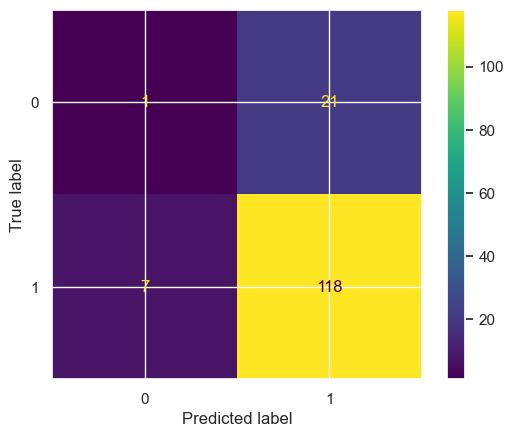

In [48]:
# K-nn classifier

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(train_set, train_y)
train_score = knn.score(train_set, train_y)
test_score = knn.score(test_set, test_y)

print(train_score, test_score)

scores = cross_val_score(knn, test_set, test_y, cv=3)
print(scores)

plot_confusion_matrix(estimator=knn, X=test_set, y_true=test_y)



LogisticRegression() -  	 train score: 0.8767006802721088,	 test score: 0.8639455782312925
                     Feature  Importance
18                  OverTime        1.74
0                        Age        1.11
15             MonthlyIncome        0.91
3                 Department        0.66
27        YearsInCurrentRole        0.64
19         PercentSalaryHike        0.64
10            JobInvolvement        0.58
11                  JobLevel        0.55
14             MaritalStatus        0.51
13           JobSatisfaction        0.35
7    EnvironmentSatisfaction        0.34
2                  DailyRate        0.31
25           WorkLifeBalance        0.30
9                 HourlyRate        0.25
29      YearsWithCurrManager        0.22
21  RelationshipSatisfaction        0.22
22          StockOptionLevel        0.16
24     TrainingTimesLastYear        0.11
23         TotalWorkingYears        0.08
5                  Education        0.07
26            YearsAtCompany        0.02
1      

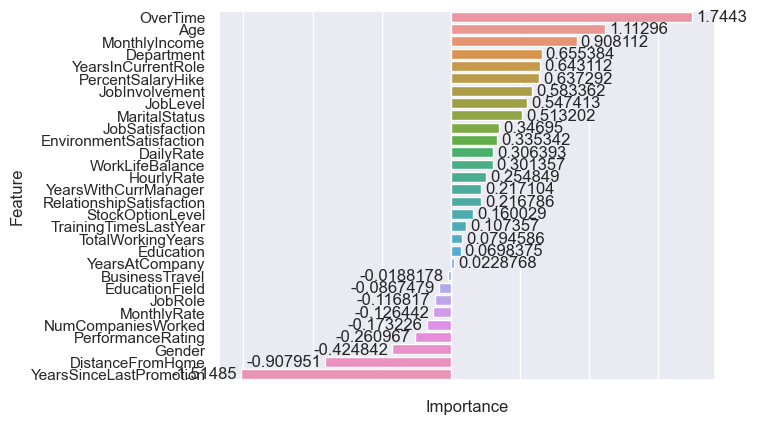

In [46]:
# Multinomial NB

mnb = LogisticRegression()

mnb.fit(train_set, train_y)
train_score = mnb.score(train_set, train_y)
test_score = mnb.score(test_set, test_y)

print('{} -  \t train score: {},\t test score: {}'.format(
    mnb, train_score, test_score))

mnb_importances = pd.DataFrame(test_set.columns, columns=['Feature'])
mnb_importances["Importance"] = mnb.coef_[0]
mnb_importances = mnb_importances.sort_values(by='Importance', ascending=False)
print(mnb_importances)


fig = sns.barplot(data=mnb_importances, x='Importance',
                   y='Feature')
fig.set_xticklabels(fig.get_xticklabels(), rotation=90,)
for bars in fig.containers:
    fig.bar_label(bars, padding=3)
plt.show(fig)



LogisticRegression() -  	 train score: 0.8767006802721088,	 test score: 0.8639455782312925
                     Feature  Importance
18                  OverTime        5.72
0                        Age        3.04
15             MonthlyIncome        2.48
3                 Department        1.93
27        YearsInCurrentRole        1.90
19         PercentSalaryHike        1.89
10            JobInvolvement        1.79
11                  JobLevel        1.73
14             MaritalStatus        1.67
13           JobSatisfaction        1.41
7    EnvironmentSatisfaction        1.40
2                  DailyRate        1.36
25           WorkLifeBalance        1.35
9                 HourlyRate        1.29
29      YearsWithCurrManager        1.24
21  RelationshipSatisfaction        1.24
22          StockOptionLevel        1.17
24     TrainingTimesLastYear        1.11
23         TotalWorkingYears        1.08
5                  Education        1.07
26            YearsAtCompany        1.02
1      

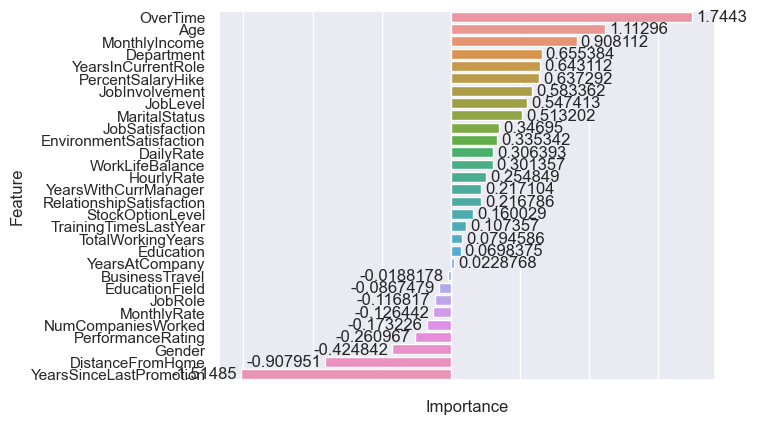

In [45]:
# Logistic Regression

lr = LogisticRegression()

lr.fit(train_set, train_y)
train_score = lr.score(train_set, train_y)
test_score = lr.score(test_set, test_y)

print('{} -  \t train score: {},\t test score: {}'.format(
    lr, train_score, test_score))

lr_importances = pd.DataFrame(test_set.columns, columns=['Feature'])
lr_importances["Importance"] = lr.coef_[0]
lr_importances = lr_importances.sort_values(by='Importance', ascending=False)
print(mnb_importances)


fig = sns.barplot(data=lr_importances, x='Importance',
                  y='Feature')
fig.set_xticklabels(fig.get_xticklabels(), rotation=90,)
for bars in fig.containers:
    fig.bar_label(bars, padding=3)
plt.show(fig)


Perceptron() -  	 train score: 0.8316326530612245,	 test score: 0.8095238095238095
                     Feature  Importance
18                  OverTime        5.72
0                        Age        3.04
15             MonthlyIncome        2.48
3                 Department        1.93
27        YearsInCurrentRole        1.90
19         PercentSalaryHike        1.89
10            JobInvolvement        1.79
11                  JobLevel        1.73
14             MaritalStatus        1.67
13           JobSatisfaction        1.41
7    EnvironmentSatisfaction        1.40
2                  DailyRate        1.36
25           WorkLifeBalance        1.35
9                 HourlyRate        1.29
29      YearsWithCurrManager        1.24
21  RelationshipSatisfaction        1.24
22          StockOptionLevel        1.17
24     TrainingTimesLastYear        1.11
23         TotalWorkingYears        1.08
5                  Education        1.07
26            YearsAtCompany        1.02
1             B

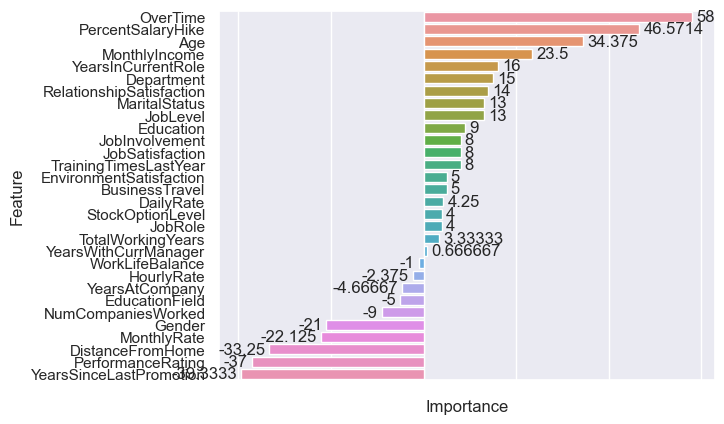

In [44]:
# Multi-layer Perceptron classifier (neural network)

# mlp = MLPClassifier(activation='relu', solver='adam', hidden_layer_sizes=(256, 64), max_iter=300)

mlp = Perceptron(tol=1e-3, random_state=0)
mlp.fit(train_set, train_y)
train_score = mlp.score(train_set, train_y)
test_score = mlp.score(test_set, test_y)

print('{} -  \t train score: {},\t test score: {}'.format(
    mlp, train_score, test_score))


mlp_importances = pd.DataFrame(test_set.columns, columns=['Feature'])
mlp_importances["Importance"] = mlp.coef_[0]
mlp_importances = mlp_importances.sort_values(by='Importance', ascending=False)
print(mnb_importances)


fig = sns.barplot(data=mlp_importances, x='Importance',
                  y='Feature')
fig.set_xticklabels(fig.get_xticklabels(), rotation=90,)
for bars in fig.containers:
    fig.bar_label(bars, padding=3)
plt.show(fig)
